# **Data Cleaning Notebook**

## Objectives

* Further data exploration
* Evaluate missing data
* Decide on imputation methods for missing data
* Split the data into Train and Test sets.

These processes need to be completed in order to satisfy the client's first business requirement:
The client is interested in discovering how the house attributes correlate with the sale price. Therefore, the client expects data visualisations of the correlated variables against the sale price to show that.


## Inputs

* /outputs/datasets/datacollection/house_prices_records.csv

## Outputs

* Generate cleaned Train and Test datasets to be stored in outputs/datasets/cleaned


## Notebook Relationship to CRISP-DM
This constitutes the data preparation stage.

## Reminder

Please use Python 3.8.12 kernel to run this notebook.

---

## Load All Imports Necessary to Run This Notebook

In [1]:
import os
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
sns.set(style="whitegrid")

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/CI-PP5-Peter-Regan-Heritage-Housing-Project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/CI-PP5-Peter-Regan-Heritage-Housing-Project'

# Load Collected Data

Load the collected house price data from the previous notebook.

In [5]:
import pandas as pd
df_raw_path = "outputs/datasets/datacollection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

Use ProfileReport from ydata_profiling library to get a more detailed understanding of the dataset.

In [6]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Preliminary Comments/Observations based on Profile Report

From a brief look at this overview, we notice that the dataset has 24 columns. 20 Columns contain numerical data and 4 contain non-numerical data. We notice in particular that the WoodDeckSF and EnclosedPorch variables are missing a considerable amount of data. Though OverallCond and OverallQual are considered numerical variables by the report, they are likely categorical variables given they have a small range of distinct values. Paired with the variable names we can likely infer they are quality ratings rather than numerical measurements.

---

# Correlation Coefficients and PPS Analysis

Let's examine the data to see how different variables are related and which variables have the biggest impact with respect to our business requirements. The functions used to calculate the Pearson and Spearman coefficients, and the PPS are taken from Code Institute's "Churnometer" walkthrough project.

In [7]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

We use CalculateCorrAndPPS to calculate the correlative coefficients and PPS and DisplayCorrAndPPS to display them.

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/home/codeany/.local

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



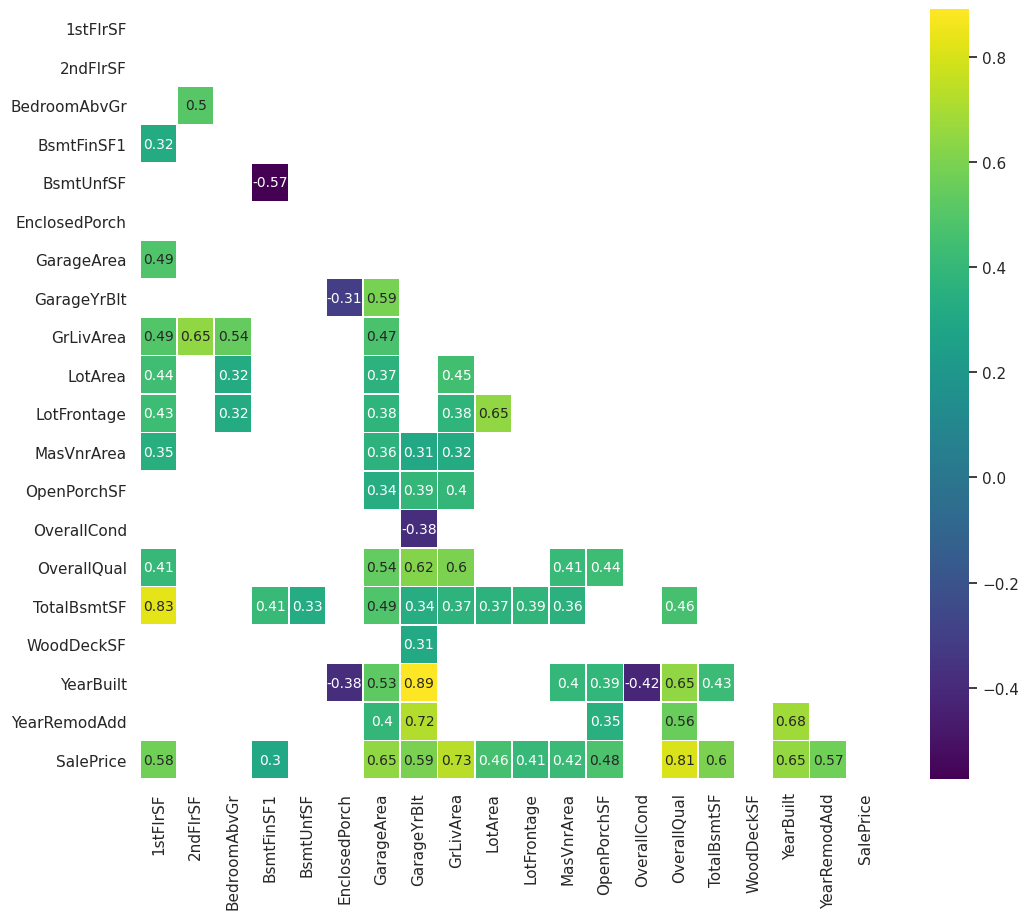



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



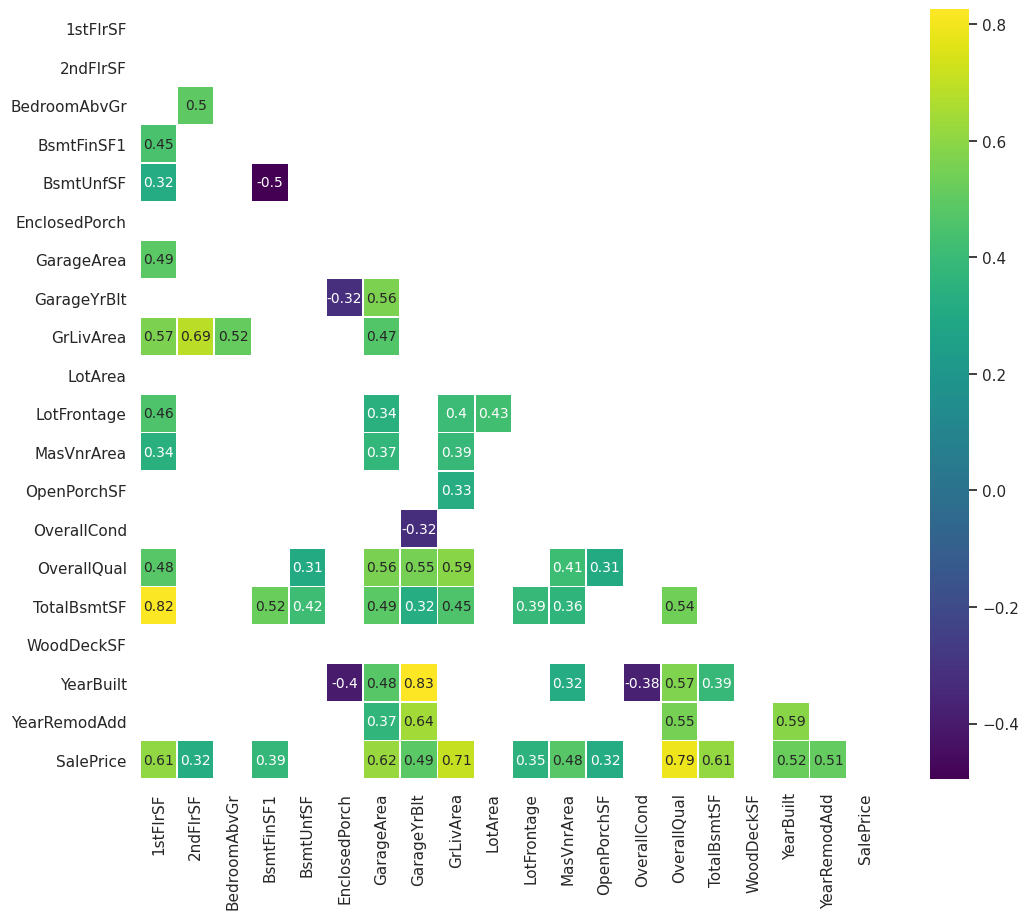



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



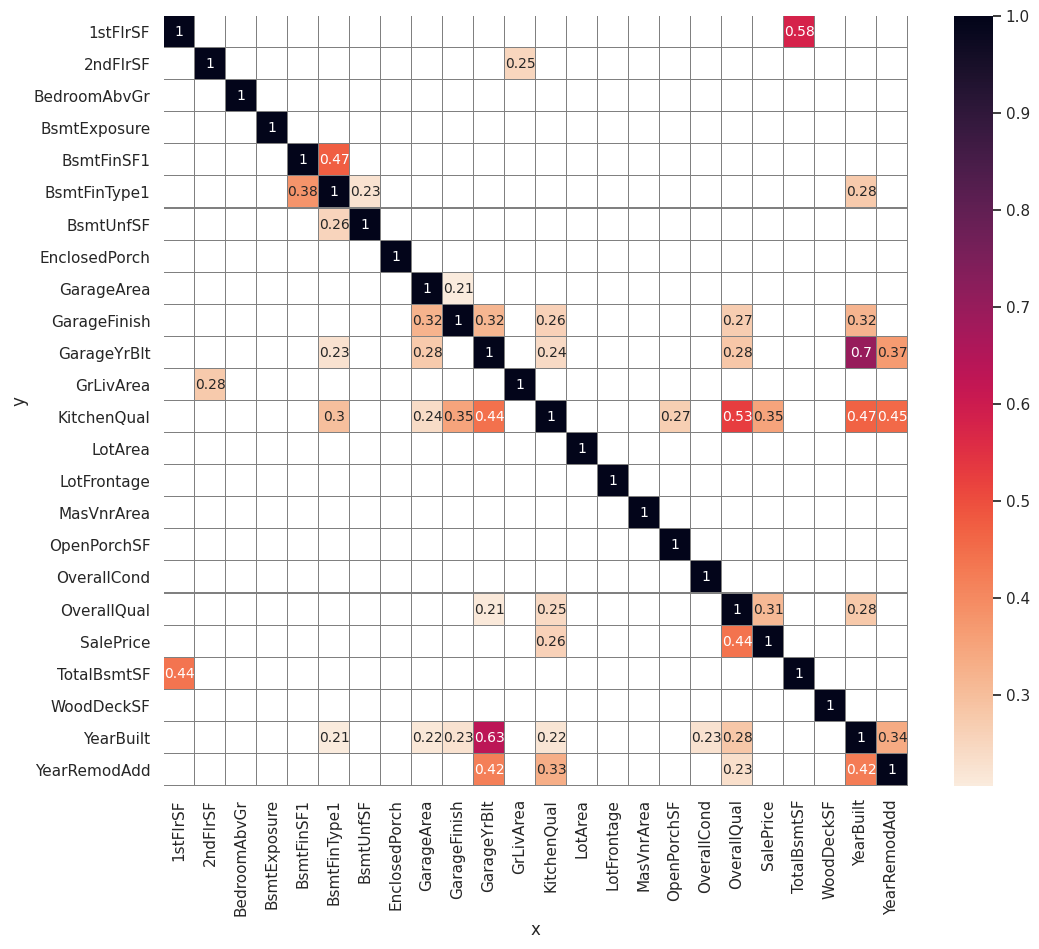

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)


# Evaluating and Visualising Missing Data

Let's explore the variables that have missing data and generate reports on them to further investigate how they influence the dataset and their effect on the overall business requirements of the client in sale price prediction. This can be done using the EvaluateMissingData function used in Code Institute's 'Churnometer' walkthrough project.

In [9]:
def EvaluateMissingData(df):
  """
  Function to visualise levels of missing data per variable within a dataframe
  """
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"DataType":df.dtypes,
                                 "RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

In [10]:
EvaluateMissingData(df)

,DataType,RowsWithMissingData,PercentageOfDataset
EnclosedPorch,float64,1324,90.68
WoodDeckSF,float64,1305,89.38
LotFrontage,float64,259,17.74
GarageFinish,object,162,11.10
BsmtFinType1,object,114,7.81
BedroomAbvGr,float64,99,6.78
2ndFlrSF,float64,86,5.89
GarageYrBlt,float64,81,5.55
MasVnrArea,float64,8,0.55


# Further Exploration of Variables with Missing Data and Proposed Methods of Imputation

Here we explore all the variables with missing data, ordered by variable with the largest proportion of missing data.

## EnclosedPorch - 90.68% of Data Missing

Given that approximately 90% of entries in the EnclosedPorch column are missing, it is not unreasonable to assume that this variable has a relatively low impact on the target variable overall. For this reason, we will drop this variable from the dataset rather than imputing a value of 0 or None.


## WoodDeckSF - 89.38% of Data Missing

Similar to the EnclosedPorch variable, we can see that approximately 90% of the data is missing here. For the same reason as listed above, we will drop this variable from the dataset.

## Lot Frontage - 17.74% of Data Missing

As this is a numerical value, we will use either a mean or median imputer. In order to decide whether to impute the mean or median, we must first check to see if the distribution of the variable is normal.




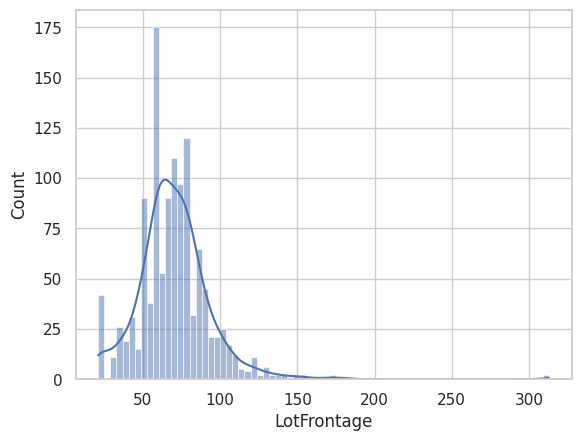

In [11]:
for col in ['LotFrontage']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()

We can see from the plot that LotFrontage has a slight positive skew and strong positive kurtosis. It is therefore not normally distributed and we should impute the median.

## GarageFinish - 11.10% of Data Missing

This variable is slightly more difficult to impute. Some of the data in this variable is missing because some GarageArea entries are 0. This means the associated house does not have a garage. Ideally, a machine model could be used to predict the GarageFinish based on other available variables present. However, at this stage of the process this is too time consuming and difficult. For now, we will simply impute an arbitrary value of "None".

## BsmtFinType1 - 7.81% of Data Missing

For reasons similar to those listed for GarageFinish, we will impute "None" for simplicity.


## BedroomAbvGr - 6.78% of Data Missing

As this is a numerical value, let's first see if the the data is normally distributed.


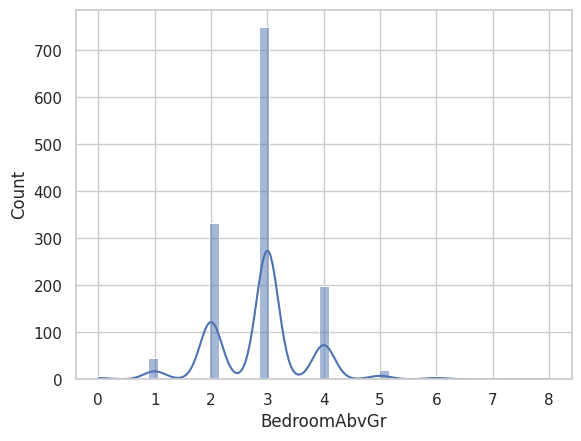

In [12]:
for col in ['BedroomAbvGr']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()

The data is not normally distributed so let's explore further.

In [13]:
# Calculate the mean
mean_value = df['BedroomAbvGr'].mean()

# Calculate the median
median_value = df['BedroomAbvGr'].median()

# Calculate the standard deviation
std_deviation = df['BedroomAbvGr'].std()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")

Mean: 2.8692138133725202
Median: 3.0
Standard Deviation: 0.8201147959370888


The mean is approximately 2.87, the median is 3 and the standard deviation is roughly 0.8. As we won't have houses with 2.87 bedrooms above ground in them, and the median and mean are fairly close, let's use median imputation in this case.

## 2ndFlrSF - 5.89% of Data Missing

Over 50% of the values for this variable are 0 indicating that there is no second floor. We can also assume that missing data also means there is no second floor. Because of this we can impute 0 for the missing values.



## GarageYrBlt - 5.55% of Data Missing

Again, let us check the distribution of this data.


In [14]:
for col in ['GarageYrBlt']:
  sns.histplot(data=TrainSet, x=col, kde=True)
  plt.show()

NameError: name 'TrainSet' is not defined

As we can see, this data is skewed and so it is probably sensible to use median imputation so the target variable is not affected by outliers. It's worth noting that there is a strong correlation between the year a house was built and the year its garage was built so a machine model could be used to predict the GarageYrBlt variable. However, for simplicity's sake at this stage let's continue with median imputation.

## MasVnrArea - 0.55% of Data Missing

Most values for this variable are 0 indicating that there is no masonry veneer. Accordingly, we can assume that missing variables indicate the absence of a masonry veneer, so we can impute 0 as a value here.



# Assess the Effects of Proposed Imputation Methods

Now that we have decided on our plan for handling variables with missing data, we must compare the proposed clean dataset against with the original dataset.

We will drop EnclosedPorch and WoodDeckSF, impute the median for GarageYrBlt, BedroomAbvGr and LotFrontage, and use arbitrary numerical or categorical imputations for the remaining variables. This will form a brand new dataframe of cleaned data that can be compared to our original dataframe.

The function used to assess the effect of the cleaning process is taken from Code Institute's lessons on Feature Engine:


In [ ]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

## Drop EnclosedPorch and WoodDeckSF

In [ ]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)

## Median Imputation for GarageYrBlt, BedroomAbvGr and LotFrontage

In [ ]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
variables_method

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Arbitrary Imputation for MsnVnrArea and 2ndFlrSF


In [ ]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['MasVnrArea', '2ndFlrSF']
variables_method

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

## Categorical Imputation for BsmtFinType1 and GarageFinish

In [ ]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['BsmtFinType1', 'GarageFinish']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)


## Assessment

As the original and cleaned datasets don't diverge too strongly, let's continue with the data cleaning process. We will now split the dataset into Train and Test sets.

# Split Data Into Train and Test Sets

Now we will split the original dataset into train and test datasets. 80% of the data will be used for the train set.

In [ ]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

Now that the data has been split, we must apply the same cleaning methods to both the train and test sets as we did to the original dataset when assessing the effect of the proposed cleaning. 

In [ ]:
# Drop Variables ['EnclosedPorch', 'WoodDeckSF']
variables_method = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

# MeanMedianImputer
variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# ArbitraryNumberImputer 
variables_method = ['2ndFlrSF','MasVnrArea']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# CategoricalImputer
variables_method = ['BsmtFinType1', 'GarageFinish']
imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)


# Arrange Methods in Data Cleaning Pipeline

We now propose a pipeline for cleaning the entire dataset.<br>
The steps are:<br>
    1. Drop EnclosedPorch and WoodDeckSF variables.<br>
    2. Median imputation for 2ndFlrSF, GarageYrBlt and LotFrontage.<br>
    3. Arbitrary numerical imputation for 2ndFlrSf and MasVnrArea.<br>
    4. Categorical imputation for GarageFinish and BsmtFinType1.<br>
    
    

In [ ]:
from sklearn.pipeline import Pipeline

data_cleaning_pipeline = Pipeline([
      ('DropFeatures', DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
      ('MedianImputer', MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'])),
      ('ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF', 'MasVnrArea'])),
      ('CategoricalImputer', CategoricalImputer(imputation_method='missing', fill_value='None', variables=['BsmtFinType1', 'GarageFinish'])),
])

df = data_cleaning_pipeline.fit_transform(df)
df.head()


---

# Push files to Repo

* Save the cleaned train and test sets to your workspace and then push the files to your repository. 

In [ ]:
try:
  # create here your folder
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

# Save the Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

# Save the Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
